## NFW Profile Model for Red LSBG Tangential Shear Measurements 

In this notebook, we walk through the process of generating a model composed of two NFW profiles to represent the tangential shear measurements for the red sample of the low surface brightness galaxy catalog. We use two NFW profiles to indicate the subhalo term and the host halo term of the measurements.  We rely on [colossus](https://bdiemer.bitbucket.io/colossus/cosmology_cosmology.html) for our base cosmology and [profiley](https://github.com/cristobal-sifon/profiley) to implement the NFW profiles. 

In [2]:
#Loading packages
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import twopoint
from profiley.nfw import TNFW, NFW
import scipy.stats as stats
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');
from astropy.cosmology import Planck15
from astropy import constants as const
import twopoint
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Measurements

We load in the red LSBG measurements (calculated using [TreeCorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html)) found in the data section of this repository. Theta_red represents the angular scales of the measurements, xi_red indicates the shear signal, error_red stands for the shot noise, and err_jk_red represents the error derived from the jackknife covariance. We conduct all of our modeling using the red galaxy sample, as this sample produces the greatest shear signal. The other galaxy samples can be found in the data section for additional testing. 

In [3]:
#Loading measurements
theta_red, xi_red, error_red, cross_term_red = np.loadtxt('../data/gt_LSBG_combined_sources_scales_3_red_ran', unpack=True)
theta_red, xi_red, err_jk_red, cross_term_red = np.loadtxt('../data/gt_LSBG_jackknife_combined_sources_scales_3_red_ran', unpack=True)
cov = np.loadtxt('../data/jkcov_gt_LSBG_combined_sources_scales_3_red_ran')


We define two functions to calculate the $\chi^2$ between the model and the tangential shear measurements and the $\Delta \chi^2$ between two models. 

In [4]:
#Chi2 function- quantitative difference between the model and the measurements
def chi2(cov, model, measurements):
    invcov = np.abs(np.linalg.inv(cov))
    chi2 = np.dot((measurements-model).T, np.dot(invcov, (measurements-model)))
    return chi2


In [5]:
#Deltachi2 function for calculating the difference between two models
def deltachi2(cov, model, measurements):
    invcov = np.abs(np.linalg.inv(cov))
    INVCOV = np.matrix(invcov)
    diff = np.matrix((model).T[0]-(measurements).T[0])
    deltachi2 = diff*INVCOV*diff.T
    return deltachi2

### Source Redshift Distribution

We load in the source redshift catalog. The catalog presents the source redshifts divided in four tomographic bins, which we weight by galaxy count, sum, and normalize to produce our source redshift distribution. We plot each of the weighted redshift bins and compare to the total distribution. 

1.0


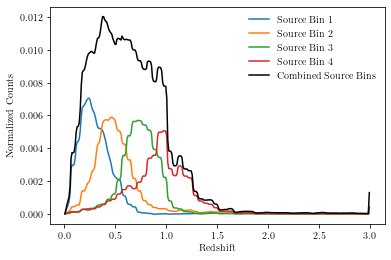

0.6312412596033679


In [6]:
#Finding mean source redshift 
T = twopoint.TwoPointFile.from_fits('../data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits') #Loading files
T.kernels[0].name
nzs = (T.kernels[0].nzs) #Galaxy counts
zsbin = (T.kernels[0].z) #Redshift spread

#Weighting the source redshift bins by galaxy count
nzs_count = np.array([24940465,25280405,24891859,25091297])
nzs_total = np.sum(nzs_count)
bins_weighted = []
for i in range(4): #Weighting bins
    bin_weighted = (nzs[i]*nzs_count[i]/nzs_total)
    bins_weighted.append(bin_weighted)

#Plotting the weighted source redshift bins
for i in range(4):
    plt.plot(zsbin, bins_weighted[i], label='Source Bin '+str(i+1))

zsdist = np.sum(bins_weighted, axis=0)
A = np.trapz(zsdist)
norm_test = np.trapz(zsdist/A) #This should equal 1
print(norm_test)
zsdist_norm = zsdist/A #Defining normalized source redshift distribution
plt.plot(zsbin, zsdist_norm, color='black', label='Combined Source Bins') #Plotting normalized source redshift distribution
plt.legend(frameon=False)
plt.xlabel('Redshift')
plt.ylabel('Normalized Counts')
plt.show()
z_mean_s = np.average(zsbin, weights=zsdist_norm)
print(z_mean_s)

### Defining Parameters

We define the parameters for the model. The NFW profile parameters include the lens redshift, the concentration (fixed at 2.0), and the mass. We require the source redshift to produce the $\Sigma_{\mathrm{crit}}$, a geometrical lensing factor that varies with the characteristics of the lensing system. Our mass terms and our mean lens redshift come from posteriors obtained with an MCMC. We build a gaussian around this mean lens redshift to construct our distribution. Our scales and our offset term (used to define the offset of the host halo profile) come from our measurements. 

In [41]:
#Model Parameters
#These parameters have been altered by playing with the chi^2 by hand
zl = 0.011 #Old model lens redshift: 13.2e-3 (from MCMC posterior)
zl_sigma = 0.005 #Spread of lens redshift distribution- made smaller to avoid negative redshifts
concentration = 2. #Concentration (taken from Sifon et al 2018)
zs = z_mean_s
theta_arcmin = np.geomspace(0.25, 1000, 25) #Scales of model
theta_rad = theta_arcmin/60*np.pi/180 
mass_term1 = 1e9 #Old model subhalo mass: 9.9e10 
mass_term2 = 5e10 #Old model host halo mass12.2e14 
offset_rad = 14/60*np.pi/180 #Scales of offset 

### Model

We build our total model from two NFW profiles to represent the subhalo and host halo term of the shear measurements. We construct a Gaussian distribution around the mean lens redshift(given by the posterior of an MCMC), normalize,and use the range of possible lens redshifts to convert our angular scales to physical scales. We then build the subhalo NFW term using the first mass term (drawn from an MCMC posterior), the concentration, and the range of possible lens redshifts. We use the mean source redshift to create the $\Sigma_\mathrm{crit}$ term. We calculate the excess surface density and the tangential shear for each of the 25 NFW profiles and integrate all of these terms over the normalized lens redshift distribution. We repeat this process for the host halo term, but we alter the scales by a normalized offset distribution. We sum these two integrated profiles to find our total model.

In [42]:
#Shear model
def total_model(mass_term1, mass_term2, zs, zl_mean, zl_sigma, theta_rad):
    zlrange = np.linspace(zl_mean - 2*zl_sigma, zl_mean + 2*zl_sigma, 30) #Range of lens redshift (changed size to 30 to better track matrices, but can be anything)
    zldist = stats.norm.pdf(zlrange, zl_mean, zl_sigma) #Lens redshift distribution
    A_zl = np.trapz(zldist) #Normalizing factor
    zldist_norm = zldist/A_zl
    
    gt_term1_list = []
    for i, xi in enumerate(zlrange):
        #Calculate the angular diameter distance for a single redshift
        da_term1 = Planck15.angular_diameter_distance(xi)
        r_mpc_term1 = da_term1*theta_rad #Transfer from angular scales to the physical radius at this single redshift
        nfw_term1 = NFW(mass_term1, concentration, xi) #NFW term for this single redshift
        sigma_crit_term1 = nfw_term1.sigma_crit([zs]) 
        esd_term1 = nfw_term1.projected_excess(r_mpc_term1)
        gt_term1 = esd_term1/sigma_crit_term1
        gt_term1_norm = gt_term1*zldist_norm[i] #We multiply by the normalized lens redshift value at the index of the current redshift
        gt_term1_list.append(gt_term1_norm)
    gt_term1_list = np.array(gt_term1_list)
    I_calc_term1 = np.trapz(gt_term1_list, axis=0) #Integrate over all of the lens redshifts
    #print(np.shape(I_calc_term1))

    
    #Offset
    r_off_dist_list = []
    r_off_norm_list = []
    
    for i, xi in enumerate(zlrange):
        #For each redshift, we have a new mean r_offset and a new distribution of points around that offset
        #We also have a new normalization factor for each redshift
        da_roff = Planck15.angular_diameter_distance(xi) #Angular diameter distance at this particular redshift
        marker_roff = np.array(offset_rad*da_roff) #We have an offset for this particular redshift (marker offset)
        sigma_roff = np.sqrt(marker_roff) 
        #Each redshift corresponds to a different range of roffs and a different distribution based around the offset
        r_off_range = np.linspace(0, marker_roff+2*sigma_roff, 40) #Range of offset physical distances (different size to make matrix tracking easier, but can be anything)
        r_off_dist = stats.norm.pdf(r_off_range, marker_roff, sigma_roff) #Offset distribution built around the marker offset 
        A_off = np.trapz(r_off_dist, axis=0) #Normalization factor
        #We divide the distribution by the normalizing factor for this redshift
        r_off_norm = r_off_dist/A_off  #Normalizing factor for offset distribution for this specific redshift
        r_off_dist_list.append(r_off_dist) #List of regular r_off_dist 
        r_off_norm_list.append(r_off_norm) #List of normalized r_off_dist for different redshifts- each of the 30 redshifts has a 40 point distribution
    #We now have a list of r_off distributions corresponding to different redshifts and a normalized distribution. We integrate over the 40 points to have a single normalization corresponding to each redshift
    r_off_norm_int = np.trapz(r_off_norm_list, axis=1)
    
    gt_term2_list = []
    for i, xi in enumerate(zlrange):
        #Calculate the angular diameter distance for a single redshift
        da_term2 = Planck15.angular_diameter_distance(xi) 
        r_mpc_term2 = da_term2*theta_rad
        nfw_term2 = NFW(mass_term2, concentration, xi)
        sigma_crit_term2 = nfw_term2.sigma_crit([zs])
        esd_term2 = nfw_term2.offset_projected_excess(np.array(r_mpc_term2), np.array(r_off_dist_list[i])) #We use the offset distribution value corresponding to this redshift
        esd_term2_int = np.trapz(esd_term2, axis=0) #We integrate over the offset distribution
        gt_term2 = (esd_term2_int/sigma_crit_term2)*zldist_norm[i]*r_off_norm_int[i] #We multiply by both the normalized lens redshift and normalized offset distribution
        gt_term2_list.append(gt_term2)
    gt_term2_list = np.array(gt_term2_list)
    I_calc_term2 = np.trapz(gt_term2_list, axis=0) #We integrate over the lens redshift
    total_model = I_calc_term1 + I_calc_term2 #Total model calculation
    return total_model, I_calc_term1, I_calc_term2


#Old model for comparison
"""def total_model(mass_term1, mass_term2, zs, zl_mean, zl_sigma, theta_rad):
    zlrange = np.linspace(zl_mean - 2*zl_sigma, zl_mean + 2*zl_sigma, 25) #Range of lens redshift
    zldist = stats.norm.pdf(zlrange, zl_mean, zl_sigma) #Lens redshift distribution
    A_zl = np.trapz(zldist) #Normalizing factor
    zldist_norm = zldist/A_zl
    
    da = Planck15.angular_diameter_distance(zlrange) #Conversion from angular to physical scales
    r_mpc = da*theta_rad
    nfw_term1 = NFW(mass_term1, concentration, zlrange) #Subhalo NFW
    print(nfw_term1)
    sigma_crit = nfw_term1.sigma_crit([zs]) #Subhalo sigma_crit for a single source redshift
    esd = nfw_term1.projected_excess(r_mpc) #Excess surface density
    gt_term1 = esd/sigma_crit #Shear calculation for 25 NFW profiles
    I_calc_term1 = np.reshape(np.trapz(gt_term1*(zldist_norm)), (25,1)) #Integrated profile over normalized lens redshift distribution
    
    da_roff = Planck15.angular_diameter_distance(zl_mean) #Scales for offset distribution
    mean_roff = np.array(offset_rad*da_roff)
    sigma_roff = np.sqrt(mean_roff)
    r_off_range = np.linspace(0, mean_roff+2*sigma_roff, 25)
    r_off_dist = stats.norm.pdf(r_off_range, mean_roff, sigma_roff) #Offset distribution
    A_off = np.trapz(r_off_dist) #Normalizing factor for offset distribution
    A_off_norm = r_off_dist/A_off
    
    nfw_term2 = NFW(mass_term2, concentration, zlrange) #Host halo NFW
    print(nfw_term2)
    sigma_crit_term2 = nfw_term2.sigma_crit([zs]) #Host halo sigma_crit
    esd_off_dist = nfw_term2.offset_projected_excess(np.array(r_mpc), np.array(r_off_dist))
    gt_term2 = esd_off_dist[0]/sigma_crit_term2
    I_calc_term2 = np.reshape(np.trapz(gt_term2*A_off_norm*zldist_norm), (25,1)) #Integrated profile over normalized lens redshift distribution for host halo term
    
    total_model = I_calc_term1+I_calc_term2 #Total model calculation
    return total_model, I_calc_term1, I_calc_term2"""


'def total_model(mass_term1, mass_term2, zs, zl_mean, zl_sigma, theta_rad):\n    zlrange = np.linspace(zl_mean - 2*zl_sigma, zl_mean + 2*zl_sigma, 25) #Range of lens redshift\n    zldist = stats.norm.pdf(zlrange, zl_mean, zl_sigma) #Lens redshift distribution\n    A_zl = np.trapz(zldist) #Normalizing factor\n    zldist_norm = zldist/A_zl\n    \n    da = Planck15.angular_diameter_distance(zlrange) #Conversion from angular to physical scales\n    r_mpc = da*theta_rad\n    nfw_term1 = NFW(mass_term1, concentration, zlrange) #Subhalo NFW\n    print(nfw_term1)\n    sigma_crit = nfw_term1.sigma_crit([zs]) #Subhalo sigma_crit for a single source redshift\n    esd = nfw_term1.projected_excess(r_mpc) #Excess surface density\n    gt_term1 = esd/sigma_crit #Shear calculation for 25 NFW profiles\n    I_calc_term1 = np.reshape(np.trapz(gt_term1*(zldist_norm)), (25,1)) #Integrated profile over normalized lens redshift distribution\n    \n    da_roff = Planck15.angular_diameter_distance(zl_mean) #Sca

In [43]:
#Call for model
total_model = total_model(mass_term1, mass_term2, zs, zl, zl_sigma, theta_rad)

### Comparison Between Model and Shear Measurements

We compare our models to our red LSBG shear measurements. Note that the model is a function of physical scales (R), while the measurements are functions of angular scales ($\theta$). The errorbars on the measurements come from the jackknife covariance. 

In [44]:
#Transfer from angular scales to physical scales based on redshift
zlrange = np.linspace(zl - 2*zl_sigma, zl+2*zl_sigma, 25)
da_term = Planck15.angular_diameter_distance(zlrange)
r_mpc = da_term*theta_rad

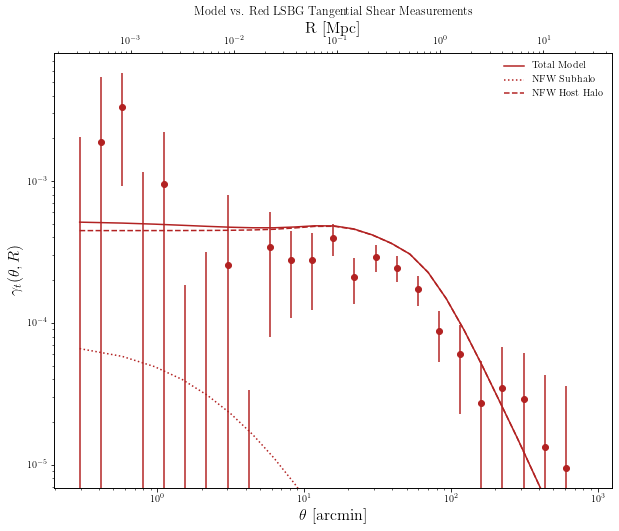

In [47]:
#Plot for measurements compared to model
fig, ax1 = plt.subplots(figsize=(10,8), ncols=1)
ax1.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies")
ax2 = ax1.twiny()
ax2.plot(r_mpc, total_model[0], color='firebrick', label = 'Total Model')
ax2.plot(r_mpc, total_model[1], ls=':', color='firebrick', label='NFW Subhalo')
ax2.plot(r_mpc, total_model[2],ls='--', color='firebrick',label='NFW Host Halo')

ax1.set_ylabel(r'$\gamma_t(\theta, R)$', fontsize=16)
ax1.set_xlabel('$\\theta$ [arcmin]', fontsize=16)
ax2.set_xlabel('R [Mpc]', fontsize=16)

ax2.legend(frameon=False)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.title('Model vs. Red LSBG Tangential Shear Measurements')
plt.show()


We include the $\chi^2$ calculations between the model and the red LSBG tangential shear measurements.

In [48]:
#Chi2 calculation between model and measurements
chi2_total = chi2(cov, total_model[0], np.reshape(xi_red, (25,1)))
print(chi2_total)

[[55.05038636]]


### Density Profile

We calculate and plot the projected surface density profile, instead of the excess surface density, as an additional check. 

In [28]:
#Density Profile Function
#Density Profile Section will be updated once the model has been fixed
"""def density_profile(mass_term1, mass_term2, zl_mean, zs, zl_sigma):
    #Setting up lens redshift distribution
    zlrange = np.linspace(zl_mean - 2*zl_sigma, zl_mean+ 2*zl_sigma, 25) #Range of lens redshifts
    zldist = stats.norm.pdf(zlrange, zl_mean, zl_sigma) #Initial distribution
    A_zl = np.trapz(zldist) #Normalizing factor
    norm_test_zl = np.trapz(zldist/A_zl) #Normalization test (should equal 1)
    zldist_norm = zldist/A_zl #Normalized distribution
 
    da_term = Planck15.angular_diameter_distance(zlrange) #Conversion from angular scales to physical scales using redshift
    r_mpc_term = da_term*theta_rad
    nfw_term1 = NFW(mass_term1, concentration, zlrange) #Generating the NFW profile
    sigma_term1 = nfw_term1.projected(r_mpc_term) #Projected surface density calculation 
    I_calc_sigma_term1 = np.reshape((np.trapz(sigma_term1)*zldist_norm), (25,1)) #Integration of surface density terms over normalized lens redshift distribution 
    
    da_roff = Planck15.angular_diameter_distance(zl_mean)
    mean_roff = np.array(offset_rad*da_roff) #Building offset distribution
    sigma_roff = np.sqrt(mean_roff)
    r_off_range = np.linspace(0, mean_roff+2*sigma_roff, 25)
    r_off_dist = stats.norm.pdf(r_off_range, mean_roff, sigma_roff)
    A_off = np.trapz(r_off_dist)
    A_norm = r_off_dist/A_off
    
    nfw_term2 = NFW(mass_term2, concentration, zlrange) #Host halo NFW profile
    sigma_term2 = nfw_term2.offset_projected(np.array(r_mpc_term), np.array(r_off_dist))[0] #projected surface density for host halo term
    I_calc_sigma_term2 = np.reshape((np.trapz(sigma_term2)*A_norm*zldist_norm), (25,1)) 
    total_density = I_calc_sigma_term1 + I_calc_sigma_term2
    return I_calc_sigma_term1, I_calc_sigma_term2, total_density"""
    

In [29]:
#sigma_term1 = density_profile(mass_term1, mass_term2, zl, zs, zl_sigma)[0]
#sigma_term2 = density_profile(mass_term1, mass_term2, zl, zs, zl_sigma)[1]
#total_density = density_profile(mass_term1, mass_term2, zl, zs, zl_sigma)[2]

We plot the density profile as a function of physical scales.

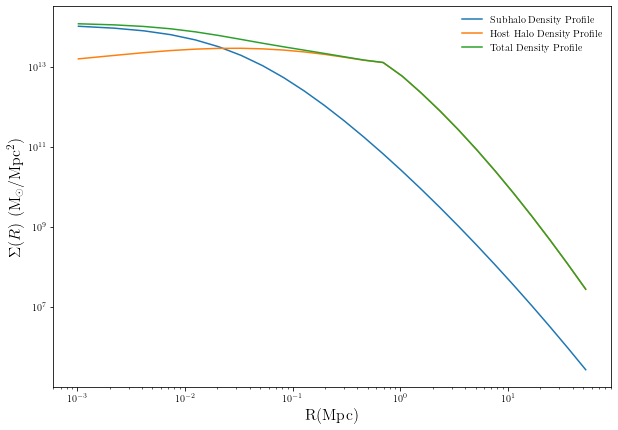

In [32]:
#Plot Density Profiles
"""fig, ax = plt.subplots(figsize=(10,7), ncols=1)
ax.plot(r_mpc, sigma_term1, label = 'Subhalo Density Profile' )
ax.plot(r_mpc, sigma_term2, label = 'Host Halo Density Profile')
ax.plot(r_mpc, sigma_term1+sigma_term2, label = 'Total Density Profile')
ax.set_ylabel(r'$\Sigma(R)$ (M$_\odot$/Mpc$^2$)', fontsize=16)
ax.set_xlabel('R(Mpc)', fontsize=16)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')"""